<a href="https://www.kaggle.com/code/khan7715/bengali-grapheme-handwriting?scriptVersionId=141416588" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- !apt-get update && apt-get install -y python3-opencv
!pip install opencv-python
!pip install scikit-learn
!pip install -U tensorflow-addons
!pip install pyarrow -->

<!-- import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) -->

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import warnings
import random


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


import cv2
import tensorflow as tf

warnings.simplefilter('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import f1_score
# import pyarrow.parquet as pq

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.applications.vit import ViT
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

D0830 05:31:46.752994103      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0830 05:31:46.753025466      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0830 05:31:46.753029998      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0830 05:31:46.753033227      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0830 05:31:46.753036399      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0830 05:31:46.753039620      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0830 05:31:46.753042622      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0830 05:31:46.

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [3]:
# declare some parameter
SEED       = 2020
batch_size = 128
dim        = (137, 236)
SIZE       = 128
stats      = (0.0692, 0.2051)
HEIGHT     = 137 
WIDTH      = 236

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10
input_shape = (dim[0], dim[1], 1)
# image_size = 72  # We'll resize input images to this size
# patch_size = 6  # Size of the patches to be extract from the input images
# num_patches = (image_size // patch_size) ** 2
# projection_dim = 64
# num_heads = 4
# transformer_units = [
#     projection_dim * 2,
#     projection_dim,
# ]  # Size of the transformer layers
# transformer_layers = 32
# mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

def seed_all(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
# seed all
seed_all(SEED)

In [4]:
# load files
im_path = '../input/grapheme-images/grapheme_images/train/'
train   = pd.read_csv('../input/bengaliai-cv19/train.csv')
test    = pd.read_csv('../input/bengaliai-cv19/test.csv')

train = train.sample(frac=1).reset_index(drop=True) # shuffling 
train['filename'] = train.image_id.apply(lambda filename: im_path + filename + '.png')

# top 5 samples
train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,filename
0,Train_145648,81,6,0,নৃ,../input/grapheme-images/grapheme_images/train...
1,Train_24895,125,7,0,ল্কে,../input/grapheme-images/grapheme_images/train...
2,Train_75994,59,7,0,ণে,../input/grapheme-images/grapheme_images/train...
3,Train_442,43,0,4,জ্য,../input/grapheme-images/grapheme_images/train...
4,Train_177898,13,9,2,র্কো,../input/grapheme-images/grapheme_images/train...


In [5]:
num_classes_1 = len(train['grapheme_root'].unique())
num_classes_2 = len(train['vowel_diacritic'].unique())
num_classes_3 = len(train['consonant_diacritic'].unique())

In [6]:
class GraphemeGenerator(keras.utils.Sequence):
    def __init__(self, data, batch_size, dim, shuffle=True, transform=None):
        self._data = data
        self._label_1 = pd.get_dummies(self._data['grapheme_root'], 
                                       columns = ['grapheme_root'])
        self._label_2 = pd.get_dummies(self._data['vowel_diacritic'], 
                                       columns = ['vowel_diacritic'])
        self._label_3 = pd.get_dummies(self._data['consonant_diacritic'], 
                                       columns = ['consonant_diacritic'])
        self._list_idx = data.index.values
        self._batch_size = batch_size
        self._dim = dim
        self._shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self._data)/self._batch_size))
    
    def __getitem__(self, index):
        batch_idx = self._indices[index*self._batch_size:(index+1)*self._batch_size]
        _idx = [self._list_idx[k] for k in batch_idx]

        Data     = np.empty((self._batch_size, *self._dim, 1))
        Target_1 = np.empty((self._batch_size, 168), dtype = int)
        Target_2 = np.empty((self._batch_size, 11 ), dtype = int)
        Target_3 = np.empty((self._batch_size,  7 ), dtype = int)
        
        for i, k in enumerate(_idx):
            # load the image file using cv2
            image = cv2.imread(im_path + self._data['image_id'][k] + '.png')
            #print(image.shape)
            #image = cv2.resize(image,  self._dim) 
            
            if self.transform is not None:
                if np.random.rand() > 0.7:
                    # albumentation : grid mask
                    res = self.transform(image=image)
                    image = res['image']
                else:
                    # augmix augmentation
                    image = augment_and_mix(image)
            
            # scaling 
            image = (image.astype(np.float32)/255.0 - stats[0])/stats[1]
            
            # gray scaling 
            gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
            image = gray(image)  
            
            # expand the axises 
            image = image[:, :, np.newaxis]
            Data[i,:, :, :] =  image
        
            Target_1[i,:] = self._label_1.loc[k, :].values
            Target_2[i,:] = self._label_2.loc[k, :].values
            Target_3[i,:] = self._label_3.loc[k, :].values
            
        return Data, [Target_1, Target_2, Target_3]
    
    
    def on_epoch_end(self):
        self._indices = np.arange(len(self._list_idx))
        if self._shuffle:
            np.random.shuffle(self._indices)

In [7]:
train_labels, val_labels = train_test_split(train, test_size = 0.20, random_state = SEED,
                                            stratify = train[['grapheme_root', 
                                                              'vowel_diacritic', 
                                                              'consonant_diacritic']])

In [8]:
# training generator
train_generator = GraphemeGenerator(train_labels, batch_size, dim, 
                                shuffle = True, transform=None)

# validation generator: no shuffle , not augmentation
val_generator = GraphemeGenerator(val_labels, batch_size, dim, 
                              shuffle = False)

In [9]:
temp = list()
for i, item in enumerate(train_generator):
    x, y = item
    print(x.shape)
    if i == 0: break
temp = x
temp = np.asarray(temp)
print(temp.shape)

(128, 137, 236, 1)
(128, 137, 236, 1)


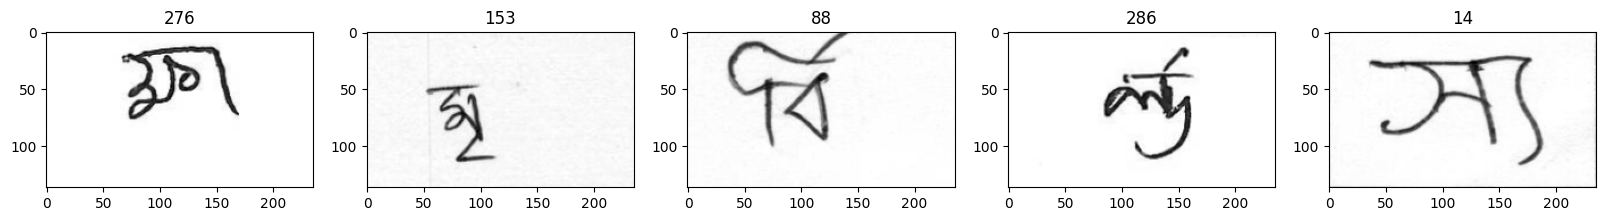

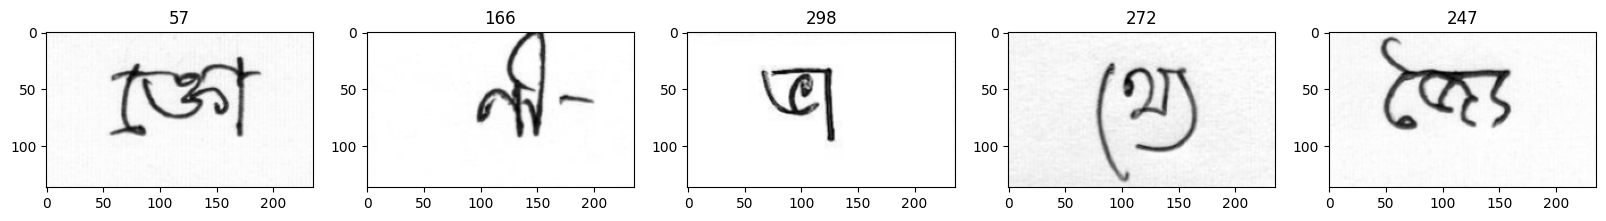

In [10]:
from pylab import rcParams

# helper function to plot sample 
def plot_imgs(dataset_show):
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, ax = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(img[0][:,:,0], cmap=plt.get_cmap('gray'))
            ax[p].set_title(idx)

# calling the above function           
plot_imgs(val_generator) 

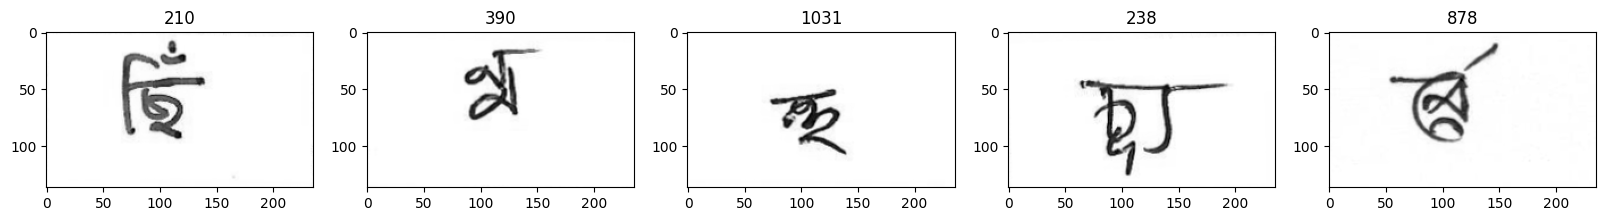

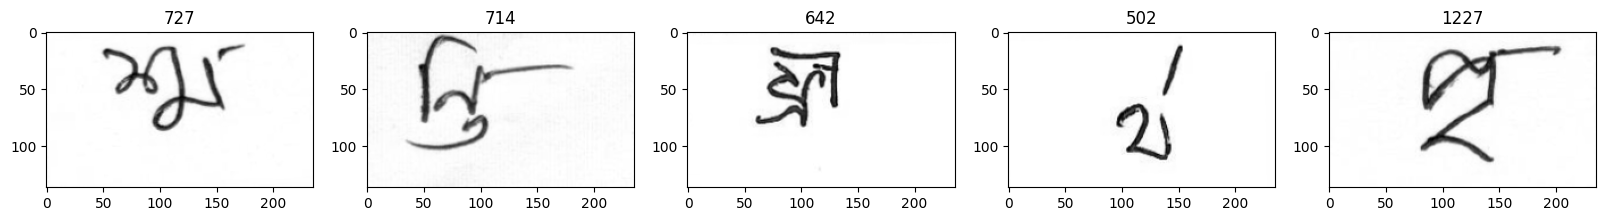

In [11]:
plot_imgs(train_generator)

Sometimes we may want to resize the images for future analysis. We can use cv2 package.

In [12]:
# data_augmentation = keras.Sequential(
#     [
#         layers.Normalization(),
#         layers.Resizing(image_size, image_size),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )

In [13]:
# def mlp(x, hidden_units, dropout_rate):
#     for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.Dropout(dropout_rate)(x)
#     return x

In [14]:
# class Patches(layers.Layer):
#     def __init__(self, patch_size):
#         super().__init__()
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

In [15]:
# plt.figure(figsize=(4, 4))
# image = temp[np.random.choice(range(temp.shape[0]))]
# plt.imshow(image.astype("uint8"))
# plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )

# print(resized_image.shape)
# patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

In [16]:
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim):
#         super().__init__()
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)
#         return encoded

In [17]:
# def create_vit_classifier():
#     inputs = layers.Input(shape=input_shape)
#     # Augment data.
#     augmented = data_augmentation(inputs)
#     # Create patches.
#     patches = Patches(patch_size)(augmented)
#     # Encode patches.
#     encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

#     # Create multiple layers of the Transformer block.
#     for _ in range(transformer_layers):
#         # Layer normalization 1.
#         x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#         # Create a multi-head attention layer.
#         attention_output = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#         )(x1, x1)
#         # Skip connection 1.
#         x2 = layers.Add()([attention_output, encoded_patches])
#         # Layer normalization 2.
#         x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#         # MLP.
#         x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
#         # Skip connection 2.
#         encoded_patches = layers.Add()([x3, x2])

#     # Create a [batch_size, projection_dim] tensor.
#     representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#     representation = layers.Flatten()(representation)
#     representation = layers.Dropout(0.5)(representation)
#     # Add MLP.
#     features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
#     # Classify outputs.
#     logits_1 = layers.Dense(num_classes_1, name='gra')(features)
#     logits_2 = layers.Dense(num_classes_2, name='vow')(features)
#     logits_3 = layers.Dense(num_classes_3, name='cons')(features)
#     # Create the Keras model.
#     model = keras.Model(inputs=inputs, outputs=[logits_1, logits_2, logits_3])
#     return model

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [19]:
def create_resnet50_classifier(input_shape, num_classes_1, num_classes_2, num_classes_3):
    # Load the ResNet50 model pre-trained on ImageNet
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a logistic layer for each set of classes
    logits_1 = Dense(num_classes_1, activation='softmax', name='gra')(x)
    logits_2 = Dense(num_classes_2, activation='softmax', name='vow')(x)
    logits_3 = Dense(num_classes_3, activation='softmax', name='cons')(x)

    # Create the Keras model
    model = Model(inputs=base_model.input, outputs=[logits_1, logits_2, logits_3])
    
    return model

In [20]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

with strategy.scope():
    res_classifier = create_resnet50_classifier(input_shape, num_classes_1, num_classes_2, num_classes_3)
    res_classifier.compile(

            optimizer = optimizer, 

            loss = {'gra' : 'categorical_crossentropy', 
                    'vow' : 'categorical_crossentropy', 
                    'cons': 'categorical_crossentropy'},

            loss_weights = {'gra' : 1.0,
                            'vow' : 1.0,
                            'cons': 1.0},

            metrics={'gra' : 'accuracy', 
                     'vow' : 'accuracy', 
                     'cons': 'accuracy'}
            )

In [21]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger)

# # some call back function; feel free to add more for experiment
# def Call_Back():
#     # model check point
#     checkpoint = ModelCheckpoint('../input/weights/bengali_grapheme_ViT.h5', 
#                                  monitor = 'val_loss', 
#                                  verbose = 0, save_best_only=True, 
#                                  mode = 'min',
#                                  save_weights_only = True)
    
#     csv_logger = CSVLogger('./weights/bg_ViT.csv')
#     early = EarlyStopping(monitor='val_loss', 
#                           mode='min', patience=5)
    
#     return [checkpoint, csv_logger, early]


# # calling all callbacks 
# callbacks = Call_Back()

#vit_classifier.load_weights('../input/weights/bengali_grapheme_ViT.h5')

In [22]:
train_history = res_classifier.fit(
    train_generator,
    steps_per_epoch=int(len(train_labels)/batch_size),  # recheck later
    validation_data=val_generator,
    validation_steps = int(len(val_labels)/batch_size), # recheck later
    epochs=num_epochs
)

Epoch 1/10


2023-08-30 05:33:29.280882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.
2023-08-30 05:33:30.440370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.


1255/1255 [==============================] - ETA: 0s - loss: 3.5693 - gra_loss: 2.5625 - vow_loss: 0.5506 - cons_loss: 0.4563 - gra_accuracy: 0.3719 - vow_accuracy: 0.8210 - cons_accuracy: 0.8542

2023-08-30 06:00:44.094947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-30 06:00:44.464222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1255/1255 [==============================] - 2102s 2s/step - loss: 3.5693 - gra_loss: 2.5625 - vow_loss: 0.5506 - cons_loss: 0.4563 - gra_accuracy: 0.3719 - vow_accuracy: 0.8210 - cons_accuracy: 0.8542 - val_loss: 2.0649 - val_gra_loss: 1.3733 - val_vow_loss: 0.3252 - val_cons_loss: 0.3664 - val_gra_accuracy: 0.6296 - val_vow_accuracy: 0.8925 - val_cons_accuracy: 0.8757
Epoch 2/10
1255/1255 [==============================] - 737s 587ms/step - loss: 0.9133 - gra_loss: 0.6101 - vow_loss: 0.1596 - cons_loss: 0.1436 - gra_accuracy: 0.8242 - vow_accuracy: 0.9520 - cons_accuracy: 0.9559 - val_loss: 18.2076 - val_gra_loss: 12.0085 - val_vow_loss: 4.9128 - val_cons_loss: 1.2863 - val_gra_accuracy: 0.0627 - val_vow_accuracy: 0.2252 - val_cons_accuracy: 0.7034
Epoch 3/10
1255/1255 [==============================] - 639s 509ms/step - loss: 0.6288 - gra_loss: 0.4072 - vow_loss: 0.1138 - cons_loss: 0.1079 - gra_accuracy: 0.8829 - vow_accuracy: 0.9675 - cons_accuracy: 0.9679 - val_loss: 1.3428 - val

In [23]:
from pathlib import Path
OUTPUT_PATH = Path('/kaggle/working/weights')
if not OUTPUT_PATH.exists():
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
res_classifier.save_weights('/kaggle/working/weights/res_classic.h5')

In [24]:
res_classifier.load_weights('/kaggle/working/weights/res_classic.h5')